In [27]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset

# Choose which network you're running

In [28]:
args = []

In [29]:
from pbranchednetwork_all import PBranchedNetwork_AllSeparateHP
PNetClass = PBranchedNetwork_AllSeparateHP
pnet_name = 'all'
p_layers = 'All Layers'
chckpt = 25
args.append((PNetClass, pnet_name, p_layers, chckpt))

# Parameters

In [30]:
engram_dir = '/mnt/smb/locker/abbott-locker/'

In [31]:
fig_dir = f'{engram_dir}hcnn/figures/'
pickle_dir = f'{engram_dir}hcnn/pickles/'
activations_dir = f'{engram_dir}hcnn/activations/'

In [32]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

checkpoints_dir = f'{engram_dir}hcnn/checkpoints/'
tensorboard_dir = f'{engram_dir}hcnn/tensorboard/'

Device: cuda:0


# Helper functions

In [33]:
def load_pnet(PNetClass, pnet_name, chckpt):
    net = BranchedNetwork(track_encoder_representations=True)
    net.load_state_dict(torch.load(f'{engram_dir}/hcnn/networks_2022_weights.pt'))
    pnet = PNetClass(net, build_graph=False)
    pnet.load_state_dict(torch.load(
        f"{checkpoints_dir}{pnet_name}/{pnet_name}-{chckpt}-regular.pth",
        map_location='cpu'
        ))
    pnet.to(DEVICE)
    pnet.eval();
    print(f'Loaded Pnet: {pnet_name}')
    print_hps(pnet)
    return pnet

In [34]:
def print_hps(pnet):
    for pc in range(pnet.number_of_pcoders):
        print (f"PCoder{pc+1} : ffm: {getattr(pnet,f'ffm{pc+1}'):0.3f} \t fbm: {getattr(pnet,f'fbm{pc+1}'):0.3f} \t erm: {getattr(pnet,f'erm{pc+1}'):0.3f}")

# Load PsychoPhysics Dataset

In [98]:
f_in = h5py.File("/mnt/smb/locker/issa-locker/users/Erica/PsychophysicsWord2017W_not_resampled.hdf5", 'r')

In [99]:
f_in_clean = h5py.File('/mnt/smb/locker/issa-locker/users/Erica/PsychophysicsWord2017W_clean_wsjOnly_fixed.hdf5','r')

In [37]:
f_metadata = np.load('/mnt/smb/locker/issa-locker/users/Erica/PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META.npy', 'r')

In [38]:
f_key = np.load('/mnt/smb/locker/issa-locker/users/Erica/PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META_key.npy', 'r')

In [39]:
with open('/mnt/smb/locker/issa-locker/users/Erica/PsychophysicsWord2017W_net_performance.p', 'rb') as f:
    net_mistakes = pickle.load(f)['net_mistakes']

In [40]:
labels = []
for word in f_metadata['word']:
    idx = np.argwhere(f_key == word)
    if len(idx) == 0:
        labels.append(-1)
    else:
        labels.append(idx.item())
labels = np.array(labels)
labels += 1

In [41]:
bg = []
for _bg in f_metadata['bg']:
    bg.append(str(_bg, 'utf-8'))
bg = np.array(bg)

In [42]:
snr = []
for _snr in f_metadata['snr']:
    _snr = str(_snr, 'utf-8')
    if 'inf' in _snr:
        _snr = np.inf
    elif 'neg' in _snr:
        if '3' in _snr:
            _snr = -3
        elif '6' in _snr:
            _snr = -6
        elif '9' in _snr:
            _snr = -9
        else:
            raise ValueError('Not found')
    else:
        if '0' in _snr:
            _snr = 0
        elif '3' in _snr:
            _snr = 3
        else:
            raise ValueError('Not found')
    snr.append(_snr)
snr = np.array(snr)

In [43]:
orig_dset = []
for _orig_dset in f_metadata['orig_dset']:
    _orig_dset = str(_orig_dset, 'utf-8')
    _orig_dset = 'WSJ' if 'WSJ' in _orig_dset else 'Timit'
    orig_dset.append(_orig_dset)
orig_dset = np.array(orig_dset)

# Save network activations

In [44]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [45]:
exclude_timit = True
bg_types = [ 'Babble8Spkr']

In [23]:
@torch.no_grad()
def save_activations(
    pnet, exclude_timit, idx_range
    ):
    
    timesteps = []
    distances = []
    snrs = []
    splits = []
    encodetypes = []
    pred_accs = []
    all_results = {}
    n_timesteps = 5
    
    for idx in idx_range:
        print(idx)
        idx_results = {}
        
        # Exclusion criteria
        if exclude_timit and orig_dset[idx] != 'WSJ':
            continue
       
        
        # Clean input
       
        clean_input = torch.tensor(
            f_in_clean['data'][idx].reshape((1, 1, 164, 400)))
        timestep_results = {}
        idx_results['timestep_results_clean'] = timestep_results
        # Activations with clean input
        pnet.reset()
        for j in range(n_timesteps):
            #print(j)
            _input = clean_input if j == 0 else None
            if _input is not None:
                _input = _input.to(DEVICE)
            logits, _ = pnet(_input)
            #print(logits)
            clean_output = logits.max(-1)[1].item()
            clean_acc = clean_output == labels[idx]
            clean_repr_dict = pnet.backbone.encoder_repr
            #             for key in ['conv1', 'conv2', 'conv3', 'conv4_W']:
            #                 del noisy_repr_dict[key]
            timestep_results[j] = {}
            timestep_results[j]['clean_output'] = clean_output
            timestep_results[j]['clean_repr_dict'] = clean_repr_dict
            #import pdb; pdb.set_trace()

     
       
        
            
        # Noisy input
        noisy_input = torch.tensor(
            f_in['data'][idx].reshape((1, 1, 164, 400)))
        timestep_results = {}
        idx_results['timestep_results'] = timestep_results
        # Activations with noisy input
        #import pdb; pdb.set_trace()
        pnet.reset()
        for j in range(n_timesteps):
            #print(j)
            _input = noisy_input if j == 0 else None
            if _input is not None:
                _input = _input.to(DEVICE)
            logits, _ = pnet(_input)
            #print(logits)
            noisy_output = logits.max(-1)[1].item()
            noisy_acc = noisy_output == labels[idx]
            noisy_repr_dict = pnet.backbone.encoder_repr
#             for key in ['conv1', 'conv2', 'conv3', 'conv4_W']:
#                 del noisy_repr_dict[key]
            timestep_results[j] = {}
            timestep_results[j]['noisy_output'] = noisy_output
            timestep_results[j]['noisy_repr_dict'] = noisy_repr_dict
            #import pdb; pdb.set_trace()
            
        all_results[idx] = idx_results
        #print(all_results.keys())
    print(all_results.keys())
                        
    return all_results

In [24]:
len(labels)

15262

In [ ]:

for arg in args:
    print('hello')
    PNetClass, pnet_name, p_layers, chckpt = arg
    pnet = load_pnet(PNetClass, pnet_name, chckpt)
    
    
    bg_type = 'Babble8Spkr'
    exclude_timit = True
    exclude_correct = True
    exclude_incorrect = False
    desired_snr = -9

    bg_idxs = bg==bg_type
    if exclude_timit:
        bg_idxs = np.logical_and(bg_idxs, orig_dset=='WSJ')
    if exclude_incorrect:
        net_corrects = np.logical_not(net_mistakes)
        bg_idxs = np.logical_and(bg_idxs, net_corrects)
    if exclude_correct:
        bg_idxs = np.logical_and(bg_idxs, net_mistakes)
    print(len(bg_idxs))
    bg_idxs = [ii for ii, _ in enumerate(bg_idxs) if _ == True and  snr[ii] == desired_snr]

    for ii in range(0, len(bg_idxs), 500):
        print(len(bg_idxs))
        all_results = save_activations(
            pnet, exclude_timit,  bg_idxs[ii:ii+500]
            )
        #print(all_results)
        with open(f'{activations_dir}{pnet_name}_withCleanTimesteps_{bg_type}-{desired_snr}-{exclude_timit}-{exclude_correct}-{exclude_incorrect}-{ii}-{ii+500}.p', 'wb') as f:
                pickle.dump(all_results, f)
        print('saved')

hello
Loaded Pnet: all
PCoder1 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder2 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder3 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder4 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder5 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
15262
530
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8231
8232
8233
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8258
8259
8260
8261
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8302
8303
8306
8307
8308
8310
8311
8312
8314
8315
8316
8317
8318
8319
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8373
8374
8375
8376
8377
8378
8379
83

In [ ]:

def _writeHDF5UnitActivations():
    #Write an HDF5 of unit activations to all cochleagrams in stimulus_files
    #But first checks that file doesn't already exist (since getting activations is computationally expensive)

    unit_activations_hdf5_path = 

        with h5py.File(self.unit_activations_hdf5_path, 'x') as f_out:
                #Create dataset store pointer to dataset object in dictionary
                dataset_dict = {}
                for layer in number_of_units_per_layer.keys():
                    for timestep in range(5):
                        dim = (self.number_of_cochleagrams,) + self.number_of_units_per_layer[layer]
                        dataset_dict[layer][timestep] = f_out.create_dataset(layer, dim , dtype='float32')

                current_index = 0

                for _, path in enumerate(self.stimulus_files):
                    print 'Getting activations for hdf5 file number '+ str(_) + ' out of '+ str(len(self.stimulus_files))
                    with h5py.File(path, 'r') as f_in:
                        for ind in range(len(f_in[self.keyword])):
                            with self.graph.as_default() as g:

                                batch = f_in[self.keyword][ind:ind+1,0:self.coch_size_flattened]
                                if 'keep_prob' in self.tensors:
                                        measures = self.session.run(self.tensors, feed_dict={self.tensors['x']: batch, self.tensors['y_label']: [0]*1, self.tensors['keep_prob']:1})
                                else:
                                        measures = self.session.run(self.tensors, feed_dict={self.tensors['x']: batch, self.tensors['y_label']: [0]*1})

                                for layer in self.number_of_units_per_layer.keys():
                                    dataset_dict[layer][current_index] =  np.array(np.squeeze(measures[layer]))
                            current_index += 1

                            if current_index %100 ==0:
                                    print 'current_index: ' + str(current_index)
    else:
        print "Note: unit activations hdf5 for this model and set of cochleagrams already exists."

In [1]:
print('hello')

hello


In [12]:
import pickle
import numpy as np

In [13]:
path = '/mnt/smb/locker/abbott-locker/hcnn/activations/all_withCleanTimesteps_50-100.p'
file = open(path,'rb')

acts = pickle.load(file)

In [16]:
number_of_units_per_layer = {}
for layer in ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']:
    number_of_units_per_layer[layer] = np.shape(acts[50]['timestep_results_clean'][0]['clean_repr_dict'][layer])

In [17]:
print(number_of_units_per_layer)

{'conv1': (96, 55, 134), 'conv2': (256, 14, 34), 'conv3': (512, 7, 17), 'conv4_W': (1024, 7, 17), 'conv5_W': (512, 7, 17), 'fc6_W': (4096,)}


In [ ]:
@torch.no_grad()
def save_activations(
    pnet, exclude_timit, idx_range
    ):
    
    timesteps = []
    distances = []
    snrs = []
    splits = []
    encodetypes = []
    pred_accs = []
    all_results = {}
    n_timesteps = 5
    
    
    unit_activations_hdf5_path = 

    with h5py.File(self.unit_activations_hdf5_path, 'x') as f_out:
            #Create dataset store pointer to dataset object in dictionary
            dataset_dict = {}
            for layer in number_of_units_per_layer.keys():
                for timestep in range(n_timesteps):
                    dim = (len(idx_range), + number_of_units_per_layer[layer]
                    dataset_dict[layer+'_'+str(timestep)+'_activations'] = f_out.create_dataset(layer+'_'+str(timestep)+'_activations', dim , dtype='float32')
                    dataset_dict[layer+'_'+str(timestep)+'_output'] = f_out.create_dataset(layer+'_'+str(timestep)+'_output', len(idx_range), dtype='float32')

    
        for idx in idx_range:
            print(idx)
         


            # Clean input

            clean_input = torch.tensor(
                f_in_clean['data'][idx].reshape((1, 1, 164, 400)))

            # Activations with clean input
            pnet.reset()
            for j in range(n_timesteps):
                #print(j)
                _input = clean_input if j == 0 else None
                if _input is not None:
                    _input = _input.to(DEVICE)
                logits, _ = pnet(_input)
                #print(logits)
                clean_output = logits.max(-1)[1].item()
                clean_acc = clean_output == labels[idx]
                clean_repr_dict = pnet.backbone.encoder_repr
                for key in ['conv1', 'conv2', 'conv3', 'conv4_W']:


        
            
        # Noisy input
        noisy_input = torch.tensor(
            f_in['data'][idx].reshape((1, 1, 164, 400)))
        timestep_results = {}
        idx_results['timestep_results'] = timestep_results
        # Activations with noisy input
        #import pdb; pdb.set_trace()
        pnet.reset()
        for j in range(n_timesteps):
            #print(j)
            _input = noisy_input if j == 0 else None
            if _input is not None:
                _input = _input.to(DEVICE)
            logits, _ = pnet(_input)
            #print(logits)
            noisy_output = logits.max(-1)[1].item()
            noisy_acc = noisy_output == labels[idx]
            noisy_repr_dict = pnet.backbone.encoder_repr
#             for key in ['conv1', 'conv2', 'conv3', 'conv4_W']:
#                 del noisy_repr_dict[key]
            timestep_results[j] = {}
            timestep_results[j]['noisy_output'] = noisy_output
            timestep_results[j]['noisy_repr_dict'] = noisy_repr_dict
            #import pdb; pdb.set_trace()
            
        all_results[idx] = idx_results
        #print(all_results.keys())
    print(all_results.keys())
                        
    return all_results

In [ ]:

for arg in args:
    print('hello')
    PNetClass, pnet_name, p_layers, chckpt = arg
    pnet = load_pnet(PNetClass, pnet_name, chckpt)
    
    
    bg_type = 'Babble8Spkr'
    exclude_timit = True
    exclude_correct = True
    exclude_incorrect = False
    desired_snr = -9

    bg_idxs = bg==bg_type
    if exclude_timit:
        bg_idxs = np.logical_and(bg_idxs, orig_dset=='WSJ')
    if exclude_incorrect:
        net_corrects = np.logical_not(net_mistakes)
        bg_idxs = np.logical_and(bg_idxs, net_corrects)
    if exclude_correct:
        bg_idxs = np.logical_and(bg_idxs, net_mistakes)
    print(len(bg_idxs))
    bg_idxs = [ii for ii, _ in enumerate(bg_idxs) if _ == True and  snr[ii] == desired_snr]

    
    all_results = save_activations(
        pnet, exclude_timit,  bg_idxs
        )
   

In [23]:
import h5py


In [46]:

bg_type = 'Babble8Spkr'
exclude_timit = True
exclude_correct = True
exclude_incorrect = False
desired_snr = -9

bg_idxs = bg==bg_type
if exclude_timit:
    bg_idxs = np.logical_and(bg_idxs, orig_dset=='WSJ')
if exclude_incorrect:
    net_corrects = np.logical_not(net_mistakes)
    bg_idxs = np.logical_and(bg_idxs, net_corrects)
if exclude_correct:
    bg_idxs = np.logical_and(bg_idxs, net_mistakes)
print(len(bg_idxs))
bg_idxs = [ii for ii, _ in enumerate(bg_idxs) if _ == True and  snr[ii] == desired_snr]



idx_range = bg_idxs

15262


In [55]:
timesteps = []
distances = []
snrs = []
splits = []
encodetypes = []
pred_accs = []
all_results = {}
n_timesteps = 5


unit_activations_hdf5_path = 'temp4.hdf5'

with h5py.File(unit_activations_hdf5_path, 'x') as f_out:
        #Create dataset store pointer to dataset object in dictionary
        dataset_dict = {}
        for layer in number_of_units_per_layer.keys():
            for timestep in range(n_timesteps):
                dim = (len(idx_range),) + number_of_units_per_layer[layer]
                dataset_dict[layer+'_'+str(timestep)+'_activations'] = f_out.create_dataset(layer+'_'+str(timestep)+'_activations', dim , dtype='float32')
                dataset_dict[str(timestep)+'_output'] = f_out.create_dataset(layer+'_'+str(timestep)+'_output', len(idx_range), dtype='float32')

In [102]:

bg_type = 'Babble8Spkr'
exclude_timit = True
exclude_correct = True
exclude_incorrect = False
desired_snr = 3

bg_idxs = bg==bg_type
if exclude_timit:
    bg_idxs = np.logical_and(bg_idxs, orig_dset=='WSJ')
if exclude_incorrect:
    net_corrects = np.logical_not(net_mistakes)
    bg_idxs = np.logical_and(bg_idxs, net_corrects)
if exclude_correct:
    bg_idxs = np.logical_and(bg_idxs, net_mistakes)
print(len(bg_idxs))
bg_idxs = [ii for ii, _ in enumerate(bg_idxs) if _ == True and  snr[ii] == desired_snr]



idx_range = bg_idxs
print('hello')
PNetClass, pnet_name, p_layers, chckpt = args[0]
pnet = load_pnet(PNetClass, pnet_name, chckpt)
    
timesteps = []
distances = []
snrs = []
splits = []
encodetypes = []
pred_accs = []
all_results = {}
n_timesteps = 5

clean = True
if clean: 
    unit_activations_hdf5_path = f'CLEAN_{bg_type}_{desired_snr}_exclude_timit_{exclude_timit}_exclude_correct_{exclude_correct}_exclude_incorrect_{exclude_incorrect}.hdf5'
else: 
    unit_activations_hdf5_path = f'NOISY_{bg_type}_{desired_snr}_exclude_timit_{exclude_timit}_exclude_correct_{exclude_correct}_exclude_incorrect_{exclude_incorrect}.hdf5'

with h5py.File(unit_activations_hdf5_path, 'x') as f_out:
        #Create dataset store pointer to dataset object in dictionary
        dataset_dict = {}
        for layer in number_of_units_per_layer.keys():
            for timestep in range(n_timesteps):
                dim = (len(idx_range),) + number_of_units_per_layer[layer]
                dataset_dict[layer+'_'+str(timestep)+'_activations'] = f_out.create_dataset(layer+'_'+str(timestep)+'_activations', dim , dtype='float32')
                if layer == 'conv1':
                    print('done')
                    dataset_dict[str(timestep)+'_output'] = f_out.create_dataset(str(timestep)+'_output', len(idx_range), dtype='float32')
        for big_idx, idx in enumerate(idx_range):
            print(idx)
         
            # Clean input
            if clean: 
                cgram = torch.tensor(
                    f_in_clean['data'][idx].reshape((1, 1, 164, 400)))
            else:
                cgram = torch.tensor(
                    f_in['data'][idx].reshape((1, 1, 164, 400)))
            # Activations with clean input
            pnet.reset()
            for j in range(n_timesteps):
                #print(j)
                _input = cgram if j == 0 else None
                if _input is not None:
                    _input = _input.to(DEVICE)
                logits, _ = pnet(_input)
                #print(logits)
                clean_output = logits.max(-1)[1].item()
                clean_acc = clean_output == labels[idx]
                clean_repr_dict = pnet.backbone.encoder_repr
                for key in ['conv1', 'conv2', 'conv3', 'conv4_W', 'fc6_W']:
                    dataset_dict[key+'_'+str(j)+'_activations'][big_idx] = clean_repr_dict[key]
                dataset_dict[str(j)+'_output'][big_idx] = clean_output 
                           


15262
hello
Loaded Pnet: all
PCoder1 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder2 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder3 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder4 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder5 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
done
done
done
done
done
6457
6458
6459
6460
6461
6462
6464
6466
6471
6473
6474
6475
6476
6478
6479
6480
6481
6482
6483
6486
6487
6489
6490
6491
6492
6494
6496
6498
6499
6501
6503
6504
6505
6506
6508
6509
6510
6512
6513
6515
6518
6519
6522
6523
6525
6528
6531
6534
6535
6537
6538
6539
6541
6542
6543
6545
6547
6548
6550
6553
6554
6555
6557
6559
6560
6562
6563
6564
6566
6568
6569
6570
6572
6573
6574
6575
6577
6578
6580
6581
6584
6585
6586
6587
6588
6589
6593
6596
6597
6598
6599
6602
6603
6604
6609
6611
6612
6613
6614
6615
6617
6618
6619
6620
6621
6623
6627
6629
6631
6632
6633
6635
6642
6643
6644
6645
6647
6654
6655
6657
6661
6662
6663
6665
6666
6667
6668
6669
6670
6674
6675
6676
6680
6681
6683
6684
6685
6686
6687
6688
6694
6696
6

In [83]:
print(unit_activations_hdf5_path)

NOISY_Babble8Spkr_-9_exclude_timit_True_exclude_correct_True_exclude_incorrect_False.hdf5


In [103]:
with h5py.File(unit_activations_hdf5_path, 'r') as f_in:
    print(f_in.keys())
    for ii in range(500):
        for t in range(5):
            print(f_in[str(t)+'_output'][ii], labels[idx_range[ii]])
        print()

<KeysViewHDF5 ['0_output', '1_output', '2_output', '3_output', '4_output', 'conv1_0_activations', 'conv1_1_activations', 'conv1_2_activations', 'conv1_3_activations', 'conv1_4_activations', 'conv2_0_activations', 'conv2_1_activations', 'conv2_2_activations', 'conv2_3_activations', 'conv2_4_activations', 'conv3_0_activations', 'conv3_1_activations', 'conv3_2_activations', 'conv3_3_activations', 'conv3_4_activations', 'conv4_W_0_activations', 'conv4_W_1_activations', 'conv4_W_2_activations', 'conv4_W_3_activations', 'conv4_W_4_activations', 'conv5_W_0_activations', 'conv5_W_1_activations', 'conv5_W_2_activations', 'conv5_W_3_activations', 'conv5_W_4_activations', 'fc6_W_0_activations', 'fc6_W_1_activations', 'fc6_W_2_activations', 'fc6_W_3_activations', 'fc6_W_4_activations']>
27.0 0
27.0 0
27.0 0
27.0 0
27.0 0

120.0 1
130.0 1
165.0 1
165.0 1
165.0 1

128.0 2
2.0 2
2.0 2
2.0 2
221.0 2

3.0 3
3.0 3
3.0 3
3.0 3
3.0 3

4.0 4
4.0 4
4.0 4
4.0 4
4.0 4

4.0 5
4.0 5
4.0 5
4.0 5
4.0 5

7.0 7
7.0

318.0 318
318.0 318
318.0 318
318.0 318

493.0 319
493.0 319
493.0 319
493.0 319
493.0 319

153.0 321
153.0 321
183.0 321
153.0 321
153.0 321

235.0 322
109.0 322
313.0 322
109.0 322
109.0 322

324.0 324
324.0 324
324.0 324
324.0 324
324.0 324

328.0 328
509.0 328
509.0 328
509.0 328
509.0 328

329.0 329
329.0 329
329.0 329
329.0 329
329.0 329

150.0 0
150.0 0
150.0 0
226.0 0
469.0 0

444.0 331
331.0 331
331.0 331
330.0 331
330.0 331

333.0 333
333.0 333
333.0 333
333.0 333
98.0 333

335.0 335
335.0 335
335.0 335
335.0 335
335.0 335

336.0 336
336.0 336
336.0 336
336.0 336
336.0 336

267.0 0
171.0 0
171.0 0
267.0 0
267.0 0

53.0 0
53.0 0
53.0 0
53.0 0
303.0 0

342.0 342
342.0 342
342.0 342
342.0 342
342.0 342

344.0 344
344.0 344
344.0 344
344.0 344
344.0 344

235.0 0
235.0 0
235.0 0
238.0 0
0.0 0

346.0 346
346.0 346
346.0 346
346.0 346
346.0 346

490.0 348
490.0 348
490.0 348
241.0 348
239.0 348

349.0 349
349.0 349
349.0 349
349.0 349
349.0 349

351.0 351
351.0 351
351.0 351
329.0 3

IndexError: Index (328) out of range for (0-327)

In [93]:
print(labels)

[  0   1   2 ... 528 529 530]


In [ ]:

def row_rms(A, B):
    """
    RMS across rows
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    
    if len(A.shape) == 1:
        stim = A - B
        return np.sqrt(np.mean(stim * stim, axis = 0))
    
    rmses = []
    for idx in range(A.shape[0]):
        a = A[idx]
        b = B[idx]
        a, b = a.T, b.T
        stim = (a - b)
        out = np.sqrt(np.mean(stim * stim, axis = 0))
        rmses.append(out)
    return np.mean(rmses)

def rms(A, B):
    """
    RMS of flattened vectors
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    A = A.flatten()
    B = B.flatten()
        
    stim = A - B
    out = np.sqrt(np.mean(stim * stim))

    return out

def corr(A, B):
    """
    RMS of flattened vectors
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    A = A.flatten()
    B = B.flatten()
    
    return np.corrcoef(A,B)[0][1]

def tanimoto_distance(A, B):
    """
    Tanimoto distance of flattened vector
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    A = A.flatten()
    B = B.flatten()
    
    _out = np.dot(A, B)/(np.linalg.norm(A)**2 + np.linalg.norm(B)**2 - np.dot(A,B))
    return _out
    
def cosine_similarity(A, B):
    """
    Cosine similarity of flattened vector
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    A = A.flatten()
    B = B.flatten()
    
    if len(A.shape) == 1:
        return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))
    
    out = []
    for channel in range(n_channels):
        a = A[channel]
        b = B[channel]
        _out = np.dot(a, b)/(np.linalg.norm(a)+np.linalg.norm(b)-np.dot(a,b))
        if np.isnan(_out):
            print(f'nan: {np.linalg.norm(a)}, {np.linalg.norm(b)}')
        out.append(_out)

    return np.mean(out)

In [60]:
def make_distance_plot(acts, layer, distance_metric):
    to_plot = []

    for jj in range(50):
            temp = []
  
            for ii in range(5):
                if distance_metric == 'tanimoto':
                    temp.append(tanimoto_distance(acts[jj]['clean_repr_dict'][layer], acts[jj]['timestep_results'][ii]['noisy_repr_dict'][layer]))
                elif distance_metric == 'cosine':
                    temp.append(cosine_similarity(acts[jj]['clean_repr_dict'][layer], acts[jj]['timestep_results'][ii]['noisy_repr_dict'][layer]))
                elif distance_metric == 'rms':
                    temp.append(rms(acts[jj]['clean_repr_dict'][layer], acts[jj]['timestep_results'][ii]['noisy_repr_dict'][layer]))
                elif distance_metric =='cka':
                    temp.append(cka(gram_linear(acts[jj]['clean_repr_dict'][layer])), gram_linear(acts[jj]['timestep_results'][ii]['noisy_repr_dict'][layer]))
               
            to_plot.append(temp)
      
    plt.plot(np.array(to_plot).T)
    plt.title(layer )
    plt.xticks(range(5), range(0,5))
    plt.ylabel(distance_metric)
    plt.xlabel('time step')
    plt.show()

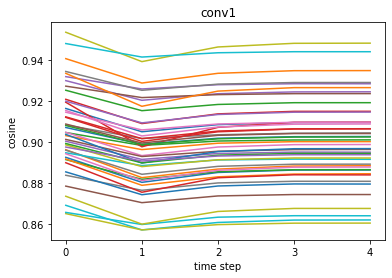

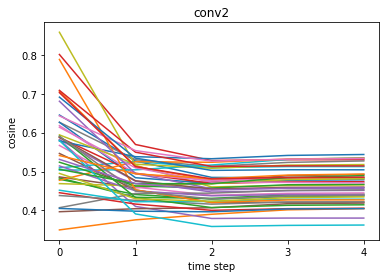

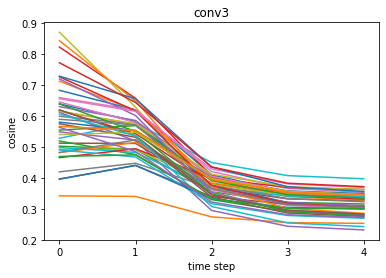

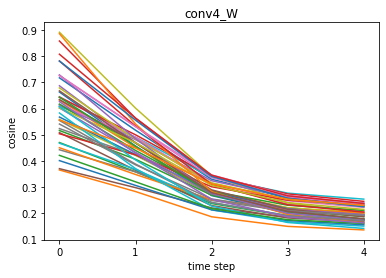

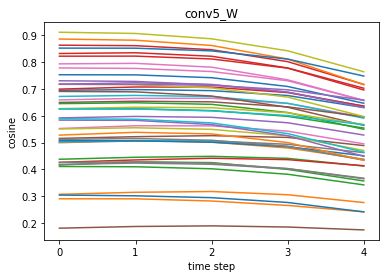

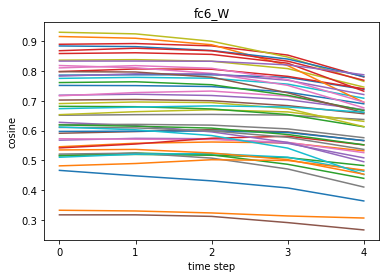

In [120]:
for layer in  ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']:
    make_distance_plot(acts, layer, 'cosine')

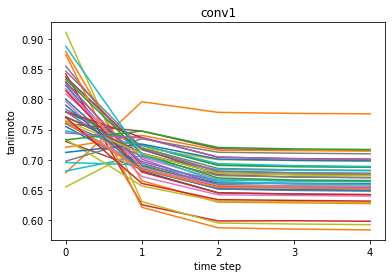

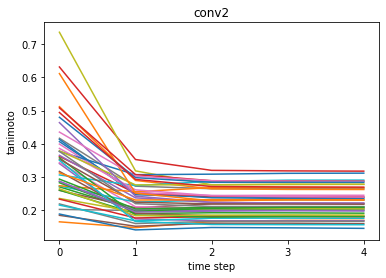

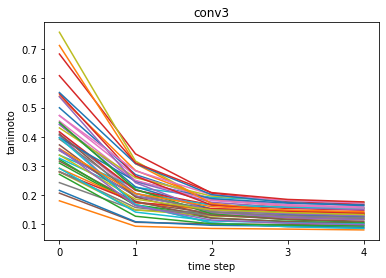

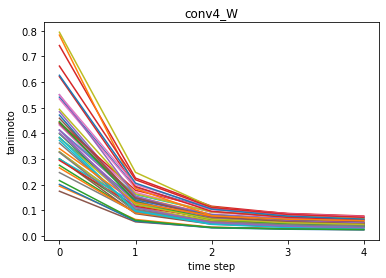

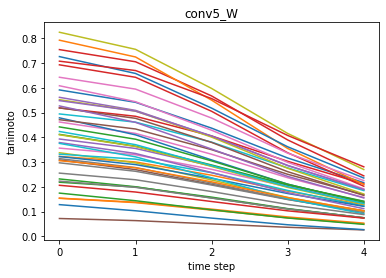

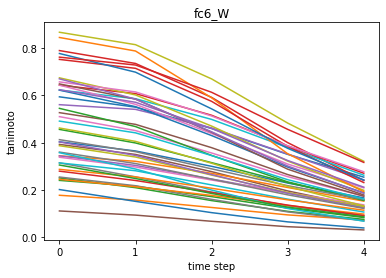

In [121]:
for layer in  ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']:
    make_distance_plot(acts, layer, 'tanimoto')

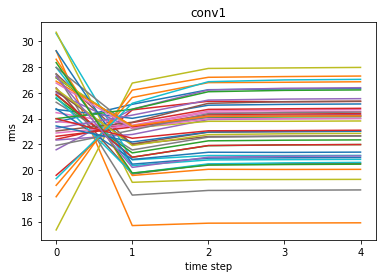

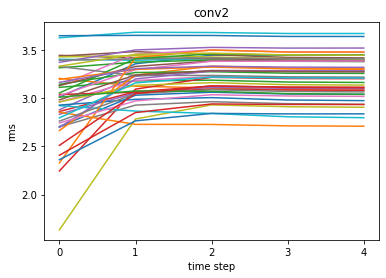

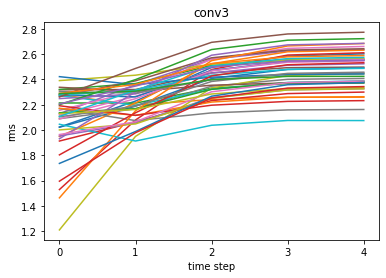

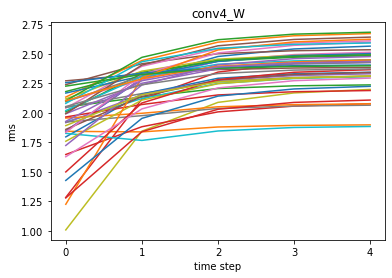

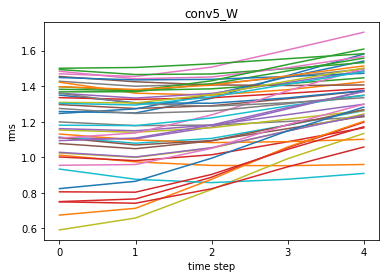

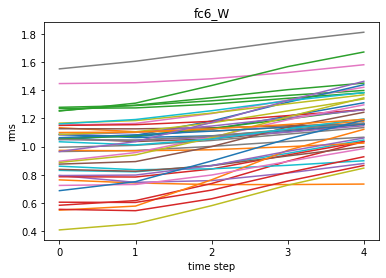

In [122]:
for layer in  ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']:
    make_distance_plot(acts, layer, 'rms')

In [127]:
for layer in  ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']:
    make_distance_plot(acts, layer, 'cka')

ValueError: shapes (96,55,134) and (134,55,96) not aligned: 134 (dim 2) != 55 (dim 1)

In [112]:
tanimoto_distance(np.array([2,0,0,1]), np.array([2,0,0,1]))

0.9999999999999997

In [106]:
import numpy as np

def gram_linear(x):
  """Compute Gram (kernel) matrix for a linear kernel.

  Args:
    x: A num_examples x num_features matrix of features.

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
  """Compute Gram (kernel) matrix for an RBF kernel.

  Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  dot_products = x.dot(x.T)
  sq_norms = np.diag(dot_products)
  sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
  sq_median_distance = np.median(sq_distances)
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
  """Center a symmetric Gram matrix.

  This is equvialent to centering the (possibly infinite-dimensional) features
  induced by the kernel before computing the Gram matrix.

  Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

  Returns:
    A symmetric matrix with centered columns and rows.
  """
  if not np.allclose(gram, gram.T):
    raise ValueError('Input must be a symmetric matrix.')
  gram = gram.copy()

  if unbiased:
    # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
    # L. (2014). Partial distance correlation with methods for dissimilarities.
    # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
    # stable than the alternative from Song et al. (2007).
    n = gram.shape[0]
    np.fill_diagonal(gram, 0)
    means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
    means -= np.sum(means) / (2 * (n - 1))
    gram -= means[:, None]
    gram -= means[None, :]
    np.fill_diagonal(gram, 0)
  else:
    means = np.mean(gram, 0, dtype=np.float64)
    means -= np.mean(means) / 2
    gram -= means[:, None]
    gram -= means[None, :]

  return gram


def cka(gram_x, gram_y, debiased=False):
  """Compute CKA.

  Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

  Returns:
    The value of CKA between X and Y.
  """
  gram_x = center_gram(gram_x, unbiased=debiased)
  gram_y = center_gram(gram_y, unbiased=debiased)

  # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
  # n*(n-3) (unbiased variant), but this cancels for CKA.
  scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

  normalization_x = np.linalg.norm(gram_x)
  normalization_y = np.linalg.norm(gram_y)
  return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(
    xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y,
    n):
  """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
  # This formula can be derived by manipulating the unbiased estimator from
  # Song et al. (2007).
  return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """
  features_x = features_x - np.mean(features_x, 0, keepdims=True)
  features_y = features_y - np.mean(features_y, 0, keepdims=True)

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))

  if debiased:
    n = features_x.shape[0]
    # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)

conv1 0.60035753
conv1 0.5657806
conv1 0.57519406
conv1 0.57661074
conv1 0.57591426
conv2 0.8908636
conv2 0.79200757
conv2 0.76074034
conv2 0.7430153
conv2 0.7313599
conv3 0.93646306
conv3 0.87841064
conv3 0.74335843
conv3 0.6457618
conv3 0.6057505
conv4_W 0.9544813
conv4_W 0.9249326
conv4_W 0.8613163
conv4_W 0.80050313
conv4_W 0.7520952
conv5_W 0.94945246
conv5_W 0.94964635
conv5_W 0.9476863
conv5_W 0.94281167
conv5_W 0.93280655
fc6_W 0.897835
fc6_W 0.90083617
fc6_W 0.8988973
fc6_W 0.8894994
fc6_W 0.8688263


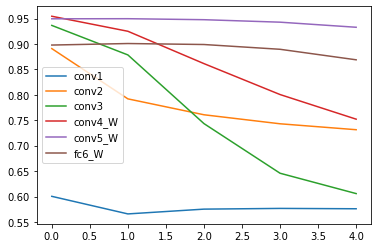

In [143]:

to_plot = []



for layer in  ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']:
    clean_vals = []
    for jj in range(50):
        
        if jj in acts.keys():
            clean_vals.append(np.ndarray.flatten(acts[jj]['clean_repr_dict'][layer]))

    to_plot = []
    for kk in range(5):
        noisy_vals = []
        for jj in range(50):
            if jj in acts.keys():
                noisy_vals.append(np.ndarray.flatten(acts[jj]['timestep_results'][kk]['noisy_repr_dict'][layer]))
            
        to_plot.append(cka(gram_linear(np.array(noisy_vals)), gram_linear(np.array(clean_vals))))
        print(layer, cka(gram_linear(np.array(noisy_vals)), gram_linear(np.array(clean_vals))))
    plt.plot(to_plot, label = layer)
plt.legend()

In [ ]:
## How much change representations over time?
## How much change in feedback representation overtime? 
## Split across timesteps 

In [41]:
def make_distance_plot(acts, layer, distance_metric):
    
    to_plot = []
    for jj in range(19):
        
            print()
            temp = []
            for ii in range(5):
               
            
                print(np.corrcoef(acts[jj]['timestep_results_clean'][0]['clean_repr_dict'][layer], acts[jj]['timestep_results_clean'][ii]['clean_repr_dict'][layer]))
            to_plot.append(temp)
    plt.plot(np.array(to_plot).T)
    plt.show()

In [42]:
for layer in  ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']:
    make_distance_plot(acts, layer, 'rms')

ValueError: m has more than 2 dimensions

In [72]:
print(acts.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50])


In [30]:
acts[0]['timestep_results'][0]

{'noisy_output': 229,
 'noisy_repr_dict': {'conv1': array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [1.67565422e+01, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [2.98779774e+01, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [6.18337135e+01, 5.85721169e+01, 1.93610497e+01, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [4.91282349e+01, 4.55589485e+01, 1.95008755e+01, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [4.45943871e+01, 4.50020142e+01, 3.12748280e+01, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
  
         [[0.00000000e+00, 5.46006489e+00, 7.53789663e+00, ...,
           3.29246974e+00, 3.10176992e+00, 6.30476236e+00],
          [0.00000000e+00, 0.00000000e+00, 5.20260096e+00, ...,

In [33]:
l = 50
u = 100
path = '/mnt/smb/locker/abbott-locker/hcnn/activations/all_withCleanTimesteps_'+str(l)+'-'+str(u)+'.p'
file = open(path,'rb')

acts = pickle.load(file)
interesting_indices = []
for jj in range(l,u):
   
    try:
        print(' ')
        for ii in range(5):
               print(acts[jj]['timestep_results'][ii]['noisy_output'], labels[jj])
                
        if acts[jj]['timestep_results'][0]['noisy_output'] != labels[jj] and acts[jj]['timestep_results_clean'][4]['clean_output'] == labels[jj]:
            interesting_indices.append(jj)
    except:
        print('problem')

 
229 0
229 0
229 0
229 0
229 0
 
312 1
312 1
312 1
312 1
0 1
 
525 2
525 2
525 2
525 2
525 2
 
3 3
3 3
3 3
3 3
3 3
 
393 4
393 4
393 4
4 4
4 4
 
5 5
5 5
5 5
5 5
5 5
 
6 6
6 6
6 6
6 6
6 6
 
7 7
7 7
7 7
7 7
7 7
 
8 8
8 8
8 8
8 8
8 8
 
9 9
9 9
9 9
9 9
9 9
 
10 10
10 10
10 10
10 10
10 10
 
11 11
11 11
11 11
11 11
11 11
 
12 12
12 12
12 12
345 12
301 12
 
13 13
13 13
13 13
13 13
13 13
 
126 0
326 0
326 0
326 0
326 0
 
108 14
108 14
300 14
0 14
0 14
 
15 15
15 15
15 15
62 15
62 15
 
298 16
298 16
298 16
298 16
0 16
 
17 17
17 17
17 17
17 17
0 17
 
46 18
24 18
254 18
0 18
0 18
 
problem
 
problem
 
problem
 
459 0
459 0
459 0
459 0
459 0
 
256 22
256 22
0 22
0 22
0 22
 
23 23
23 23
23 23
23 23
23 23
 
14 24
14 24
14 24
24 24
0 24
 
25 25
25 25
25 25
25 25
25 25
 
26 26
26 26
26 26
26 26
301 26
 
27 27
27 27
27 27
27 27
27 27
 
129 28
129 28
129 28
28 28
28 28
 
29 29
29 29
29 29
29 29
29 29
 
problem
 
31 31
31 31
31 31
31 31
0 31
 
63 32
63 32
30 32
30 32
30 32
 
337 33
337 33
337 33
337 33

In [28]:
print(interesting_indices)

[4]


In [36]:
f_metadata[4]

(b'AudScene_0db-acquire-13-3.1-wsj1-si_tr_s-47h-47hc020s.wav', 4, 0, 32000, b'AudScene_0db', b'AudScene', b'0db', b'acquire', b'WSJ_AudScene_0db', b'13-3.1/wsj1/si_tr_s/47h/47hc020s.wav', b'47h', -1)

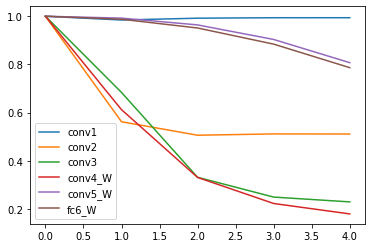

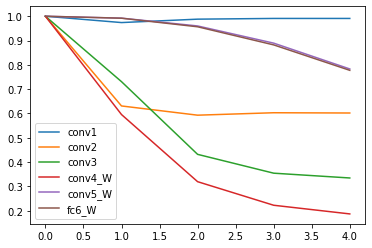

In [62]:
for jj in range(4,6):
    
    for layer in  ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']:
        to_plot = []
        for ii in range(5):
            to_plot.append(corr(acts[jj]['timestep_results_clean'][0]['clean_repr_dict'][layer], acts[jj]['timestep_results_clean'][ii]['clean_repr_dict'][layer]))
        plt.plot(to_plot, label = layer)
    plt.legend()
    plt.show()

In [ ]:
## Look at graces measure for ones where the network was wrong but then got it right with recurrence 

In [ ]:
def eval_correlations(
    pnet, bg_type='n/a',
    exclude_timit=True, exclude_correct=True, exclude_incorrect=False
    ):
    
    bg_idxs = bg==bg_type
    if exclude_timit:
        bg_idxs = np.logical_and(bg_idxs, orig_dset=='WSJ')
    if exclude_incorrect:
        net_corrects = np.logical_not(net_mistakes)
        bg_idxs = np.logical_and(bg_idxs, net_corrects)
    if exclude_correct:
        bg_idxs = np.logical_and(bg_idxs, net_mistakes)
    
    timesteps = []
    correlations = []
    snrs = []
    encoders = []
    pred_accs = []
    
    n_timesteps = 5
    for snr_type in np.unique(snr):
        dset_idxs = np.logical_and(bg_idxs, snr==snr_type)
        dset_idxs = np.argwhere(dset_idxs).squeeze()
        for idx in dset_idxs:
            # Clean input
            clean_input = clean_in[idx]
            clean_input = torch.tensor(clean_input.reshape((1, 1, 164, 400))).clone()
            clean_input = clean_input.to(DEVICE)
            pnet.reset()
            outputs, _ = pnet(clean_input)
            clean_repr_dict = pnet.backbone.encoder_repr
            
            # Noisy input
            _input = torch.tensor(f_in['data'][idx].reshape((1, 1, 164, 400)))
            pnet.reset()
            with torch.no_grad():
                base_rms = {}
                for j in range(n_timesteps):
                    _input = _input if j == 0 else None
                    if _input is not None:
                        _input = _input.to(DEVICE)
                    outputs, _ = pnet(_input)
                    output = outputs.max(-1)[1].item()
                    pred_acc = output == labels[idx]
                    noisy_repr_dict = pnet.backbone.encoder_repr
                    for enc_num, enc_name in enumerate(['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']):
                        noisy_repr = noisy_repr_dict[enc_name]
                        clean_repr = clean_repr_dict[enc_name]
                        _rms = row_rms(noisy_repr, clean_repr)
                        if j == 0:
                            base_rms[enc_name] = _rms
                        timesteps.append(j)
                        correlations.append(_rms/base_rms[enc_name])
                        snrs.append(snr_type)
                        pred_accs.append(pred_acc)
                        encoders.append(enc_num+1)
    df = pd.DataFrame({
        'Timesteps': timesteps,
        'Correlation': correlations,
        'SNR': snrs,
        'Encoder': encoders,
        'PNet Accuracy': pred_accs
    })
    return df

In [82]:
bg_type = 'Babble8Spkr'
exclude_timit = True
exclude_correct = True
exclude_incorrect = False
desired_snr = -9

bg_idxs = bg==bg_type
if exclude_timit:
    bg_idxs = np.logical_and(bg_idxs, orig_dset=='WSJ')
if exclude_incorrect:
    net_corrects = np.logical_not(net_mistakes)
    bg_idxs = np.logical_and(bg_idxs, net_corrects)
if exclude_correct:
    bg_idxs = np.logical_and(bg_idxs, net_mistakes)
print(len(bg_idxs))
bg_idxs = [ii for ii, _ in enumerate(bg_idxs) if _ == True and  snr[ii] == desired_snr]
    
    

15262


In [83]:
print(np.unique(snr))

[-9. -6. -3.  0.  3. inf]


In [84]:
bg_idxs

[8219,
 8220,
 8221,
 8222,
 8223,
 8224,
 8225,
 8226,
 8227,
 8228,
 8229,
 8231,
 8232,
 8233,
 8235,
 8236,
 8237,
 8238,
 8239,
 8240,
 8241,
 8242,
 8243,
 8244,
 8245,
 8246,
 8247,
 8248,
 8249,
 8250,
 8251,
 8252,
 8253,
 8254,
 8255,
 8256,
 8258,
 8259,
 8260,
 8261,
 8263,
 8264,
 8265,
 8266,
 8267,
 8268,
 8269,
 8270,
 8271,
 8272,
 8273,
 8274,
 8275,
 8276,
 8277,
 8278,
 8279,
 8281,
 8282,
 8283,
 8284,
 8285,
 8286,
 8287,
 8288,
 8289,
 8290,
 8291,
 8292,
 8293,
 8294,
 8295,
 8296,
 8297,
 8298,
 8299,
 8300,
 8302,
 8303,
 8306,
 8307,
 8308,
 8310,
 8311,
 8312,
 8314,
 8315,
 8316,
 8317,
 8318,
 8319,
 8321,
 8322,
 8323,
 8324,
 8325,
 8326,
 8327,
 8328,
 8329,
 8330,
 8331,
 8332,
 8333,
 8334,
 8335,
 8336,
 8337,
 8340,
 8341,
 8342,
 8343,
 8344,
 8345,
 8346,
 8347,
 8348,
 8349,
 8351,
 8352,
 8353,
 8354,
 8355,
 8356,
 8357,
 8358,
 8359,
 8360,
 8361,
 8362,
 8363,
 8364,
 8365,
 8366,
 8367,
 8368,
 8369,
 8370,
 8371,
 8373,
 8374,
 8375,
 8376,

In [77]:
len(bg_idxs)

518

In [85]:
snr[bg_idxs]

array([-9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9.,
       -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9., -9